In [ ]:
!git clone https://github.com/IntelLabs/bayesian-torch
!pip install bayesian-torch/.
!pip install torch_cka

Cloning into 'bayesian-torch'...
remote: Enumerating objects: 714, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 714 (delta 292), reused 362 (delta 234), pack-reused 265
Receiving objects: 100% (714/714), 273.92 KiB | 2.61 MiB/s, done.
Resolving deltas: 100% (449/449), done.
Processing ./bayesian-torch
  Preparing metadata (setup.py) ... done
  Created wheel for bayesian-torch: filename=bayesian_torch-0.4.0-py3-none-any.whl size=77122 sha256=d5fb813112512ede27615f62264bc976b214975aca04bba29e6ae00c308a23aa
  Stored in directory: /root/.cache/pip/wheels/c4/64/36/327a5aa82508f440c69defc36b554b49f41c2b5780c95fb461
Successfully built bayesian-torch


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss



import PIL
import math
import random
import numpy as np
from tqdm import tqdm
from torch_cka import CKA
import matplotlib.pyplot as plt

torch.manual_seed(38)


In [ ]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

num_epochs = 200
batch_size = 50
learning_rate = 0.001


In [ ]:
train_aug_transform = transforms.Compose([
  transforms.Pad(4),
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32),
  transforms.ToTensor()])

train_transform = transforms.Compose([
  transforms.ToTensor()])

test_aug_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.ToTensor()])

train_dataset           = torchvision.datasets.CIFAR10(root='./data/' ,train=True,  transform=train_transform,  download=True)
train_aug_dataset       = torchvision.datasets.CIFAR10(root='./data/' ,train=True,  transform=train_aug_transform,  download=True)
test_dataset            = torchvision.datasets.CIFAR10(root='./data/' ,train=False, transform=test_transform)
test_aug_dataset        = torchvision.datasets.CIFAR10(root='./data/' ,train=False, transform=test_aug_transform)

train_loader           = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)
train_aug_loader       = torch.utils.data.DataLoader(dataset=train_aug_dataset , batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)
test_loader            = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, pin_memory=True, shuffle=False, drop_last=True )
test_aug_loader        = torch.utils.data.DataLoader(dataset=test_aug_dataset,  batch_size=batch_size, pin_memory=True, shuffle=False, drop_last=True )


100%|██████████| 170498071/170498071 [00:01<00:00, 96024819.53it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


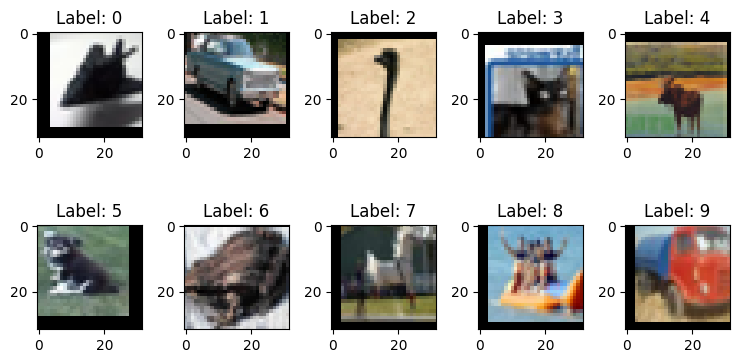

In [ ]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

# labels =
images_set = []
labels_set = []
j=0
for i in range(10):
  while i != train_aug_dataset[j][1]:
    j += 1
  images_set.append(train_aug_dataset[j][0])
  labels_set.append(train_aug_dataset[j][1])


plot_set_images(2, 5, images_set, labels_set, "Label: ")

In [ ]:
def pgd_linf_end2end(model, X, labels, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True).to(device)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model((X + delta).to(device)), labels.to(device)).to(device)
        loss.backward()
        with torch.no_grad():
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.data = torch.clamp(X + delta.data, min=0, max=1) - X
        delta.grad.zero_()
    return delta.detach()

In [ ]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

# model = torchvision.models.resnet18(pretrained=True)
# dnn_to_bnn(model, const_bnn_prior_parameters)

In [ ]:
def test(model,test_loader, eps_t2, alpha, iter_t2, test_type='st'):
  model.eval()
  total_acc_test = 0

  if test_type=='st':
    for i, (X, labels) in enumerate(test_loader):
          X = X.to(device)
          labels = labels.to(device)
          Z =  model(X)
          total_acc_test += (Z.max(dim=1)[1] == labels).sum().item()

    print('Acc_Test =', total_acc_test / len(test_loader.dataset),sep="\t")
    return total_acc_test / len(test_loader.dataset)



  elif test_type=='at':
    for i, (X, labels) in enumerate(test_loader):
          X = X.to(device)
          labels = labels.to(device)
          delta = pgd_linf_end2end(model, X, labels, eps_t2, alpha, iter_t2)
          X_adv = (X + delta)
          Z2 = model(X_adv)
          predicted2 = Z2.argmax(1)
          total_acc_test += (Z2.max(dim=1)[1] == labels).sum().item()

    print('Acc_Test =', total_acc_test / len(test_loader.dataset),sep="\t")
    return total_acc_test/len(test_loader.dataset)


In [ ]:
def train(model, train_loader, criterion,optimizer, sched, eps_AT, alpha, iter_AT, T1=1, T2=1, training_type='st'):
  model.train()

  if training_type == 'st':
    for epoch in range(num_epochs):
        losses=[]
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs =  model(images).to(device)
            loss1 = criterion(outputs, labels)
            kl = get_kl_loss(model).to(device)

            loss = ((loss1**(1.0/T1)) + ((kl / batch_size)**T2)).to(device)
            # print(loss.item())
            losses.append(loss.item())


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            # if grad_clip:
            #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            sched.step()


        if epoch%5==0:
          print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
          test(model,test_loader, eps_AT, 0.01, 20, test_type='st')
          test(model,test_aug_loader, eps_AT, 0.01, 20, test_type='st')
          test(model,test_aug_loader, eps_AT, 0.01, 20, test_type='at')
          model.train()
          print()
          print()



  elif training_type == 'at':
    for epoch in range(num_epochs):
        losses=[]
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            delta = pgd_linf_end2end(model, images, labels, eps_AT, alpha, iter_AT)
            images_adv = (images + delta)
            Z_x0 = model(images_adv).to(device)
            loss1 = criterion(Z_x0, labels).to(device)
            kl = get_kl_loss(model).to(device)

            loss = ((loss1**(1.0/T1)) + ((kl / batch_size)**T2)).to(device)
            # # print(loss.item())
            losses.append(loss.item())



#           # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            # if grad_clip:
            #     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            sched.step()


        if epoch%5==0:
          print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
          test(model,test_loader, eps_AT, 0.01, 20, test_type='st')
          test(model,test_aug_loader,eps_AT, 0.01, 20, test_type='st')
          test(model,test_aug_loader, eps_AT, 0.01, 20, test_type='at')
          model.train()
          print()
          print()


  return model, losses


In [ ]:
models = []
losses = []
test_acc = {'st_no_aug':0, 'st_aug':0, 'st_aug_at':0, 'at_no_aug':0, 'at_aug':0, 'at_aug_at':0}

model_type = ['st', 'at', 'st_c', 'at_c', 'at_c_w', 'at_w']

for mt in model_type:
  if mt=='st':
    print()
    print()
    print("Training a BNN by augmented data and standard scheme: ")
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(model.fc.in_features, 10)
    dnn_to_bnn(model, const_bnn_prior_parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
    trained_model, loss = train(model.to(device), train_aug_loader, criterion, optimizer, sched,  8/255, 0.01, 5, T1=1, T2=1, training_type='st')
    models.append(trained_model)
    # losses.append(loss)

    # test_acc['st_no_aug'] = test(model,test_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['st_aug'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['st_aug_at'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='at')


    print("###########################################################################################")

  if mt=='at':
    print()
    print()
    print("Training a BNN by augmented data and adversarial scheme: ")
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(model.fc.in_features, 10)
    dnn_to_bnn(model, const_bnn_prior_parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
    trained_model, loss = train(model.to(device), train_aug_loader, criterion, optimizer, sched, 8/255, 0.01, 5, T1=1, T2=1, training_type='at')
    models.append(trained_model)
    # losses.append(loss)

    # test_acc['at_no_aug'] = test(model,test_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['at_aug'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['at_aug_at'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='at')


    print("###########################################################################################")


  if mt=='st_c':
    print()
    print()
    print("Training a BNN by clean data and standard scheme: ")
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(model.fc.in_features, 10)
    dnn_to_bnn(model, const_bnn_prior_parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
    trained_model, loss = train(model.to(device), train_loader, criterion, optimizer, sched,  8/255, 0.01, 5, T1=1, T2=1, training_type='st')
    models.append(trained_model)
    # losses.append(loss)

    # test_acc['st_no_aug'] = test(model,test_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['st_aug'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['st_aug_at'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='at')


    print("###########################################################################################")


  if mt=='at_c':
    print()
    print()
    print("Training a BNN by clean data and adversarial scheme: ")
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(model.fc.in_features, 10)
    dnn_to_bnn(model, const_bnn_prior_parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
    trained_model, loss = train(model.to(device), train_loader, criterion, optimizer, sched,  8/255, 0.01, 5, T1=1, T2=1, training_type='at')
    models.append(trained_model)
    # losses.append(loss)

    # test_acc['st_no_aug'] = test(model,test_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['st_aug'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='st')

    # test_acc['st_aug_at'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='at')


    print("###########################################################################################")

    if mt=='at_c_w':
      print()
      print()
      print("Training a BNN by clean data and adversarial scheme and low epsilon: ")
      model = torchvision.models.resnet18(pretrained=False).to(device)
      model.fc = nn.Linear(model.fc.in_features, 10)
      dnn_to_bnn(model, const_bnn_prior_parameters)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
      trained_model, loss = train(model.to(device), train_loader, criterion, optimizer, sched, 2/255, 0.01, 5, T1=1, T2=1, training_type='at')
      models.append(trained_model)
      # losses.append(loss)

      # test_acc['at_no_aug'] = test(model,test_loader, 8/255, 0.01, 20, test_type='st')

      # test_acc['at_aug'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='st')

      # test_acc['at_aug_at'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='at')


    print("###########################################################################################")

  if mt=='at_w':
      print()
      print()
      print("Training a BNN by augmented data and adversarial scheme and low epsilon: ")
      model = torchvision.models.resnet18(pretrained=False).to(device)
      model.fc = nn.Linear(model.fc.in_features, 10)
      dnn_to_bnn(model, const_bnn_prior_parameters)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
      trained_model, loss = train(model.to(device), train_aug_loader, criterion, optimizer, sched, 2/255, 0.01, 5, T1=1, T2=1, training_type='at')
      models.append(trained_model)
      # losses.append(loss)

      # test_acc['at_no_aug'] = test(model,test_loader, 8/255, 0.01, 20, test_type='st')

      # test_acc['at_aug'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='st')

      # test_acc['at_aug_at'] = test(model,test_aug_loader, 8/255, 0.01, 20, test_type='at')






Training a BNN by augmented data and standard scheme: 


In [ ]:
def representation_comparison(model1, model2, model1_name, model2_name, dataloader1, dataloader2):
  cka = CKA(model1, model2,
            model1_name=model1_name,   # good idea to provide names to avoid confusion
            model2_name=model2_name,
            device=device)

  cka.compare(dataloader1, dataloader2) # secondary dataloader is optional

  results = cka.export()  # returns a dict that contains model names, layer names

  return results

In [ ]:
def conf_matrix(results):
  fig, ax = plt.subplots()
  im = ax.imshow(results['CKA'], origin='lower', cmap='magma')
  ax.set_xlabel(f"Layers {results['model1_name']}", fontsize=15)
  ax.set_ylabel(f"Layers {results['model2_name']}", fontsize=15)

  plt.tight_layout()

In [ ]:
results10 = representation_comparison(models[0], models[0], "Resnet18_st_aug", "Resnet18_st_aug", test_loader, test_loader)
conf_matrix(results10)

In [ ]:
results11 = representation_comparison(models[1], models[1], "Resnet18_at_aug", "Resnet18_at_aug", test_loader, test_loader)
conf_matrix(results11)

In [ ]:
results12 = representation_comparison(models[2], models[2], "Resnet18_st_clean", "Resnet18_st_clean", test_loader, test_loader)
conf_matrix(results12)

In [ ]:
results13 = representation_comparison(models[3], models[3], "Resnet18_at_clean", "Resnet18_at_clean", test_loader, test_loader)
conf_matrix(results13)

In [ ]:
results14 = representation_comparison(models[4], models[4], "Resnet18_at_w_clean", "Resnet18_at_w_clean", test_loader, test_loader)
conf_matrix(results14)

In [ ]:
results15 = representation_comparison(models[5], models[5], "Resnet18_at_w_aug", "Resnet18_at_w_aug", test_loader, test_loader)
conf_matrix(results15)

In [ ]:
results16 = representation_comparison(models[4], models[3], "Resnet18_at_w_clean", "Resnet18_at_h_clean", test_loader, test_loader)
conf_matrix(results16)

In [ ]:
results17 = representation_comparison(models[5], models[1], "Resnet18_at_w_aug", "Resnet18_at_h_aug", test_loader, test_loader)
conf_matrix(results17)

| Comparing features |: 100%|██████████| 100/100 [05:10<00:00,  3.10s/it]


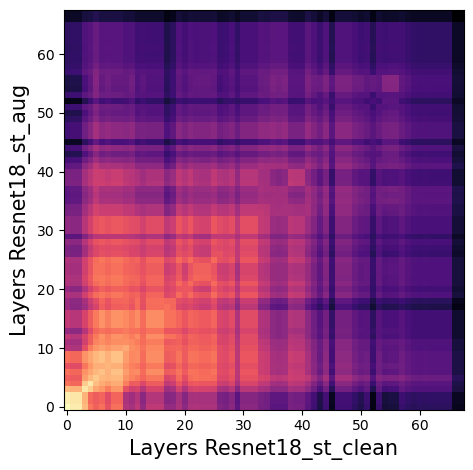

In [ ]:
results0 = representation_comparison(models[2], models[0], "Resnet18_st_clean", "Resnet18_st_aug", test_loader, test_loader)
conf_matrix(results0)

| Comparing features |: 100%|██████████| 100/100 [05:10<00:00,  3.11s/it]


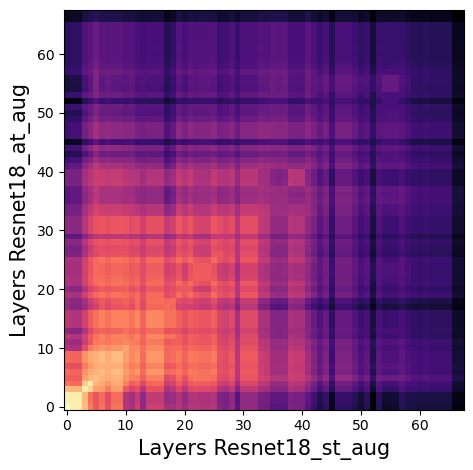

In [ ]:
results1 = representation_comparison(models[0], models[1], "Resnet18_st_aug", "Resnet18_at_aug", test_loader, test_loader)
conf_matrix(results1)

| Comparing features |: 100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


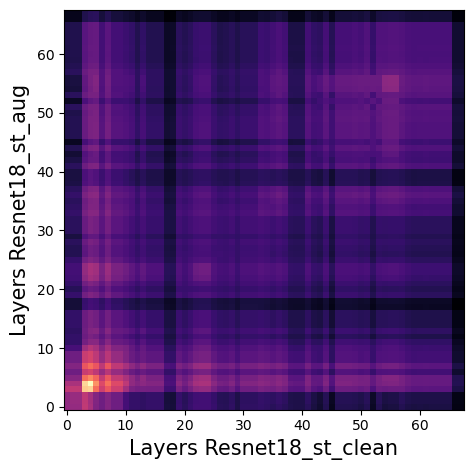

In [ ]:
results2 = representation_comparison(models[2], models[0], "Resnet18_st_clean", "Resnet18_st_aug", test_aug_loader, test_aug_loader)
conf_matrix(results2)

| Comparing features |: 100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


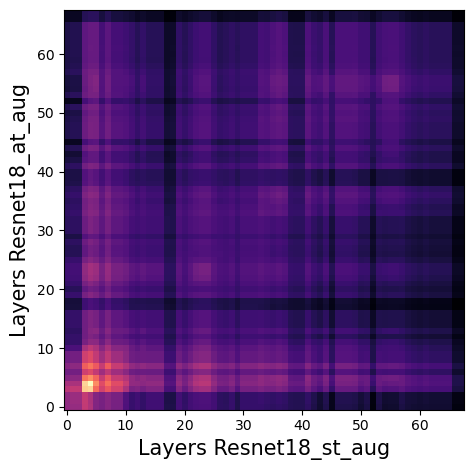

In [ ]:
results3 = representation_comparison(models[0], models[1], "Resnet18_st_aug", "Resnet18_at_aug", test_aug_loader, test_aug_loader)
conf_matrix(results3)

/scratch/work/chengg1/myconda/conda_envs/analysis_1/lib/python3.11/site-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - Resnet18_st_aug. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 100/100 [05:12<00:00,  3.13s/it]


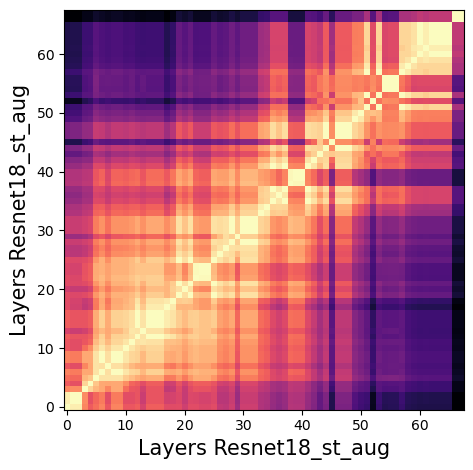

In [ ]:
results4 = representation_comparison(models[0], models[0], "Resnet18_st_aug", "Resnet18_st_aug", test_loader, test_aug_loader)
conf_matrix(results4)

/scratch/work/chengg1/myconda/conda_envs/analysis_1/lib/python3.11/site-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - Resnet18_at_aug. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


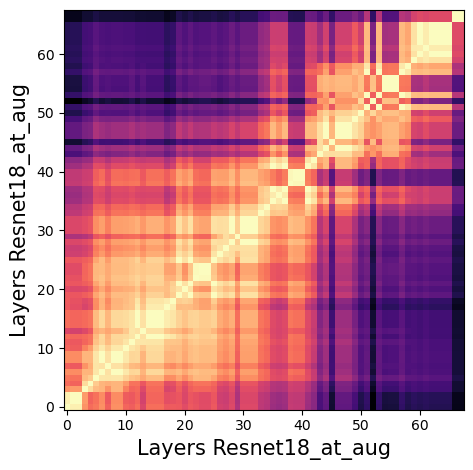

In [ ]:
results5 = representation_comparison(models[1], models[1], "Resnet18_at_aug", "Resnet18_at_aug", test_loader, test_aug_loader)
conf_matrix(results5)

| Comparing features |: 100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


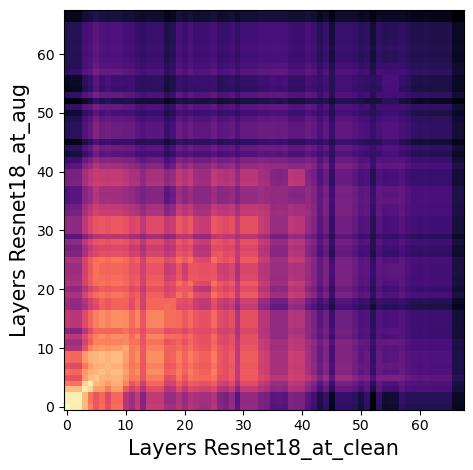

In [ ]:
results6 = representation_comparison(models[3], models[1], "Resnet18_at_clean", "Resnet18_at_aug", test_loader, test_loader)
conf_matrix(results6)

| Comparing features |: 100%|██████████| 100/100 [05:12<00:00,  3.12s/it]


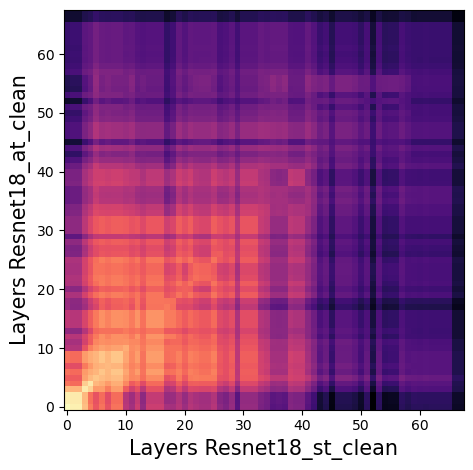

In [ ]:
results7 = representation_comparison(models[2], models[3], "Resnet18_st_clean", "Resnet18_at_clean", test_loader, test_loader)
conf_matrix(results7)

/scratch/work/chengg1/myconda/conda_envs/analysis_1/lib/python3.11/site-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - Resnet18_st_clean. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 100/100 [05:12<00:00,  3.13s/it]


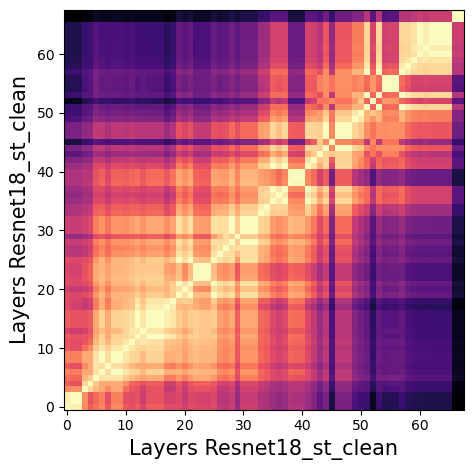

In [ ]:
results8 = representation_comparison(models[2], models[2], "Resnet18_st_clean", "Resnet18_st_clean", test_loader, test_aug_loader)
conf_matrix(results8)

/scratch/work/chengg1/myconda/conda_envs/analysis_1/lib/python3.11/site-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - Resnet18_at_clean. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 100/100 [05:13<00:00,  3.13s/it]


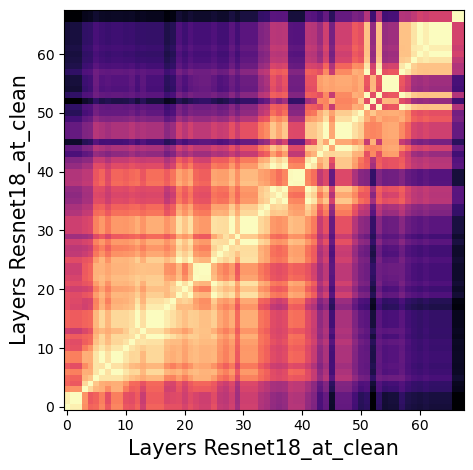

In [ ]:
results9 = representation_comparison(models[3], models[3], "Resnet18_at_clean", "Resnet18_at_clean", test_loader, test_aug_loader)
conf_matrix(results9)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
  def __init__(self, model, data_loader, eps):
    # super(Data, self).__init__()
    self.x = []
    self.y = []
    for (images, labels) in (data_loader):
          images = images.to(device)
          labels = labels.to(device)
          delta = pgd_linf_end2end(model.to(device), X=images.to(device), labels=labels.to(device),  epsilon=eps, alpha=0.01, num_iter=20).to(device)
          images_adv = (images + delta)
          self.x.append(images_adv)
          self.y.append(labels)

    self.len=len(data_loader)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.len


In [ ]:
adv_dset0 = Data(models[0].to(device), test_loader, 8/255) # st_aug
adv0_loader = torch.utils.data.DataLoader(dataset=adv_dset0, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)

adv_dset1 = Data(models[1].to(device), test_loader, 8/255) # at_aug
adv1_loader = torch.utils.data.DataLoader(dataset=adv_dset1, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)

adv_dset2 = Data(models[2].to(device), test_loader, 8/255) # st_clean
adv2_loader = torch.utils.data.DataLoader(dataset=adv_dset2, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)

adv_dset3 = Data(models[3].to(device), test_loader, 8/255) # at_clean
adv3_loader = torch.utils.data.DataLoader(dataset=adv_dset3, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)

adv_dset4 = Data(models[4].to(device), test_loader, 2/255) # at_clean_w
adv4_loader = torch.utils.data.DataLoader(dataset=adv_dset4, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)

adv_dset5 = Data(models[5].to(device), test_loader, 2/255) # at_aug_w
adv5_loader = torch.utils.data.DataLoader(dataset=adv_dset5, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)


In [ ]:
results18 = representation_comparison(models[0], models[0], "Resnet18_st_aug", "Resnet18_st_aug", test_loader, adv0_loader)
conf_matrix(results18)

In [ ]:
results19 = representation_comparison(models[1], models[1], "Resnet18_at_aug", "Resnet18_at_aug", test_loader, adv1_loader)
conf_matrix(results19)

In [ ]:
results20 = representation_comparison(models[2], models[2], "Resnet18_st_clean", "Resnet18_st_clean", test_loader, adv2_loader)
conf_matrix(results20)

In [ ]:
results21 = representation_comparison(models[3], models[3], "Resnet18_at_clean", "Resnet18_at_clean", test_loader, adv3_loader)
conf_matrix(results21)

In [ ]:
results22 = representation_comparison(models[4], models[4], "Resnet18_at_w_clean", "Resnet18_at_w_clean", test_loader, adv4_loader)
conf_matrix(results22)

In [ ]:
results23 = representation_comparison(models[5], models[5], "Resnet18_at_w_aug", "Resnet18_at_w_aug", test_loader, adv5_loader)
conf_matrix(results23)